In [15]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import pickle
import sys
import datetime as dt
from dateutil.relativedelta import *
from collections import Counter
from collections import defaultdict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from pandas_profiling import profile_report
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import shap
from prediction import PrediccionModelo

from src.utils import * 

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Test

## Evaluación modelo - full variables

In [5]:
df=pd.read_csv('outputs/preds/pred_full_07-09-2023_02_18_16.csv',sep=";")
df.head()

,pred,label,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,flag_null_payer_code,flag_null_medical_specialty,flag_null_max_glu_serum,flag_null_A1Cresult,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Male,age__40_50_,age__50_60_,age__60_70_,age__70_80_,age__80_100_,admission_type_Emergency,admission_type_Newborn,admission_type_Other,discharge_disposition_Other,admission_source_Other,admission_source_Physician Referral,max_glu_serum__300,max_glu_serum_Norm,max_glu_serum_Other,A1Cresult__8,A1Cresult_Norm,A1Cresult_Other,metformin_No,metformin_Steady,metformin_Up,glimepiride_No,glimepiride_Steady,glimepiride_Up,glipizide_No,glipizide_Steady,glipizide_Up,glyburide_No,glyburide_Steady,glyburide_Up,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,insulin_No,insulin_Steady,insulin_Up,change_No,diabetesMed_Yes,primary_diagnosis_Diabetes,primary_diagnosis_Digestive,primary_diagnosis_Genitourinary,primary_diagnosis_Injury,primary_diagnosis_Musculoskeletal,primary_diagnosis_Neoplasms,primary_diagnosis_Other,primary_diagnosis_Respiratory
0,0.129179,0,12,31,2,21,9,1,0,1,1,False,True,False,False,True,False,False,False,True,False,True,False,False,True,True,False,False,False,True,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False
1,0.098655,0,8,49,2,16,6,1,1,0,1,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False
2,0.061482,0,1,32,6,7,6,0,0,1,1,False,True,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,True,False,False,True,True,False,False,False,False,False,False,False,False
3,0.072497,0,10,52,5,17,5,0,0,1,1,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,True,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False
4,0.111186,0,4,21,0,22,9,0,1,1,1,False,True,False,False,False,False,False,False,False,True,True,False,False,True,False,True,False,False,True,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,True,False,True,False,False,False,False,True,False,False,False


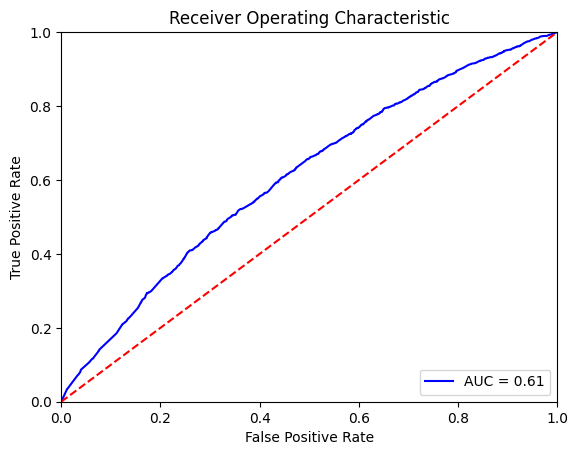

In [6]:
fpr, tpr, threshold = roc_curve(df['label'],df['pred'])
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [7]:
roc_auc_score(df['label'],df['pred'])

0.6098345219984127

In [11]:
ks=ks_table(data=df,target='label', prob='pred')
ks.to_csv('outputs/ks/ks_test_full.csv')
ks

        min_prob  max_prob  events  nonevents event_rate nonevent_rate  \
Decile                                                                   
1       0.129891  0.143846     260       1424     14.08%         7.66%   
2       0.119967  0.129680     294       1956     15.92%        10.52%   
3       0.109718  0.119905     253       1943     13.70%        10.45%   
4       0.096807  0.109578     182       1797      9.85%         9.66%   
5       0.083617  0.096634     182       1705      9.85%         9.17%   
6       0.075814  0.083536     170       2052      9.20%        11.03%   
7       0.070057  0.075803     157       1881      8.50%        10.11%   
8       0.064240  0.070052     142       1957      7.69%        10.52%   
9       0.060115  0.064237     113       1911      6.12%        10.27%   
10      0.051172  0.060109      94       1975      5.09%        10.62%   

       cum_eventrate cum_noneventrate    KS  
Decile                                       
1             14.08

,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS
Decile,,,,,,,,,
1,0.129891,0.143846,260,1424,14.08%,7.66%,14.08%,7.66%,6.4
2,0.119967,0.129680,294,1956,15.92%,10.52%,29.99%,18.17%,11.8
3,0.109718,0.119905,253,1943,13.70%,10.45%,43.69%,28.62%,15.1
4,0.096807,0.109578,182,1797,9.85%,9.66%,53.55%,38.28%,15.3
5,0.083617,0.096634,182,1705,9.85%,9.17%,63.40%,47.44%,16.0
6,0.075814,0.083536,170,2052,9.20%,11.03%,72.60%,58.48%,14.1
7,0.070057,0.075803,157,1881,8.50%,10.11%,81.10%,68.59%,12.5
8,0.064240,0.070052,142,1957,7.69%,10.52%,88.79%,79.11%,9.7
9,0.060115,0.064237,113,1911,6.12%,10.27%,94.91%,89.38%,5.5


# shap values

In [25]:
imp_variables=pd.read_csv('outputs/imp_variables/importancia_variables_v1.csv')
variables=list(imp_variables.iloc[:10,0])
imp_variables.head(10)

,Unnamed: 0,importance
0,number_diagnoses,7
1,time_in_hospital,6
2,discharge_disposition_Other,6
3,num_lab_procedures,5
4,diabetesMed_Yes,3
5,primary_diagnosis_Respiratory,3
6,flag_null_payer_code,3
7,age__50_60_,2
8,metformin_No,1
9,num_medications,1


In [28]:
features_to_drop = [
        "target",
        'pred',
        'label'
    ]
columnas = [x for x in df.columns if x not in features_to_drop]
X_test=df[list(imp_variables.iloc[:,0])]

In [29]:
model = lgb.Booster(model_file="outputs/models/model_07-09-2023_02_11_36.txt")
model.params['objective'] = 'binary'

In [31]:
# Explain model predictions using shap library:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

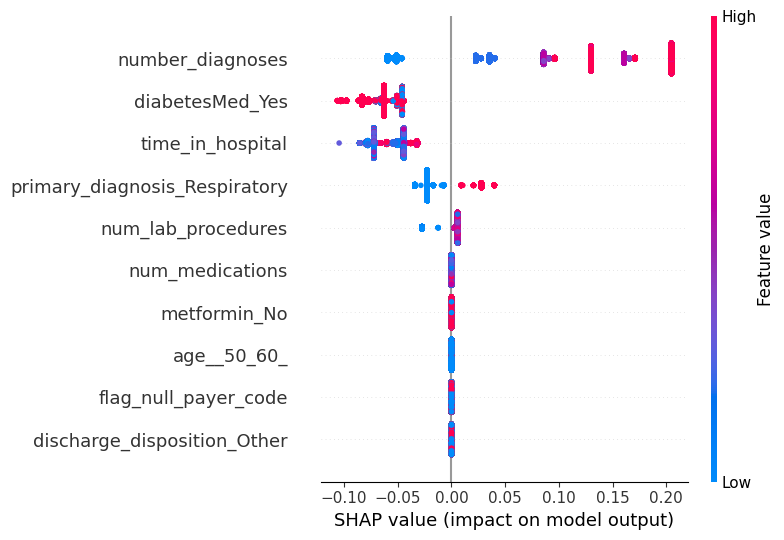

In [32]:
your_feature_indices = [X_test.iloc[:,:].columns.tolist().index(x) for x in variables]
shap.summary_plot(shap_values[1][:,your_feature_indices], X_test.iloc[:, your_feature_indices])